## 서울시 따릉이 수요 예측

#### < 라이브러리 import >

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import seaborn as sns
sns.set()
import matplotlib
from IPython.display import set_matplotlib_formats

matplotlib.rc('font', family='NanumGothic')

matplotlib.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')
%matplotlib inline

#### < 데이터 load >

In [3]:
train = pd.read_csv("./data/tmp_data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

In [4]:
print(train.shape)
train.head(5)

(1459, 11)


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


count    1459.000000
mean      108.563400
std        82.631733
min         1.000000
25%        37.000000
50%        96.000000
75%       150.000000
max       431.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'target distribution')

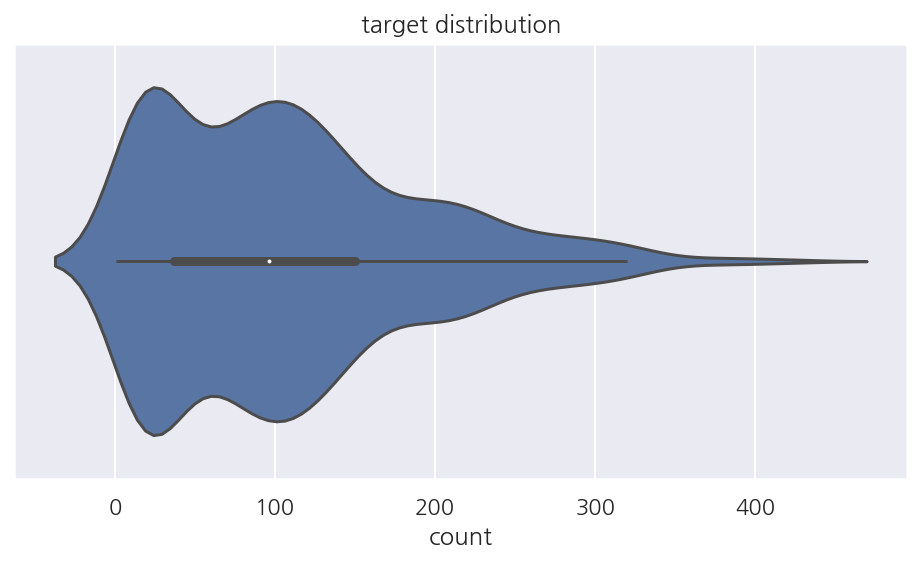

In [6]:
## target에 대한 통계량 , 분포 확인
display(train['count'].describe())

plt.figure(figsize=(8,4))
sns.violinplot(train['count'])
plt.title("target distribution")

#### < 베이스라인 모델링 >

* 베이스라인 모델
    * simple Linear Regression
    * 베이스라인 모델을 기준으로 점차 지표 개선여부 확인.

In [7]:
features = train.dropna().loc[:,:"hour_bef_pm2.5"]
target = train.dropna()['count']

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3)

# baseline model
base_model = LinearRegression()

base_model.fit(X_train,y_train)

base_pred = base_model.predict(X_test)

base_scores = cross_val_score(base_model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
base_rmse_scores = np.sqrt(-1*base_scores)
base_rmse = np.mean(base_rmse_scores)

print("base model rmse : ",base_rmse)

base model rmse :  53.32160721781468


* base model의 회귀계수 시각화

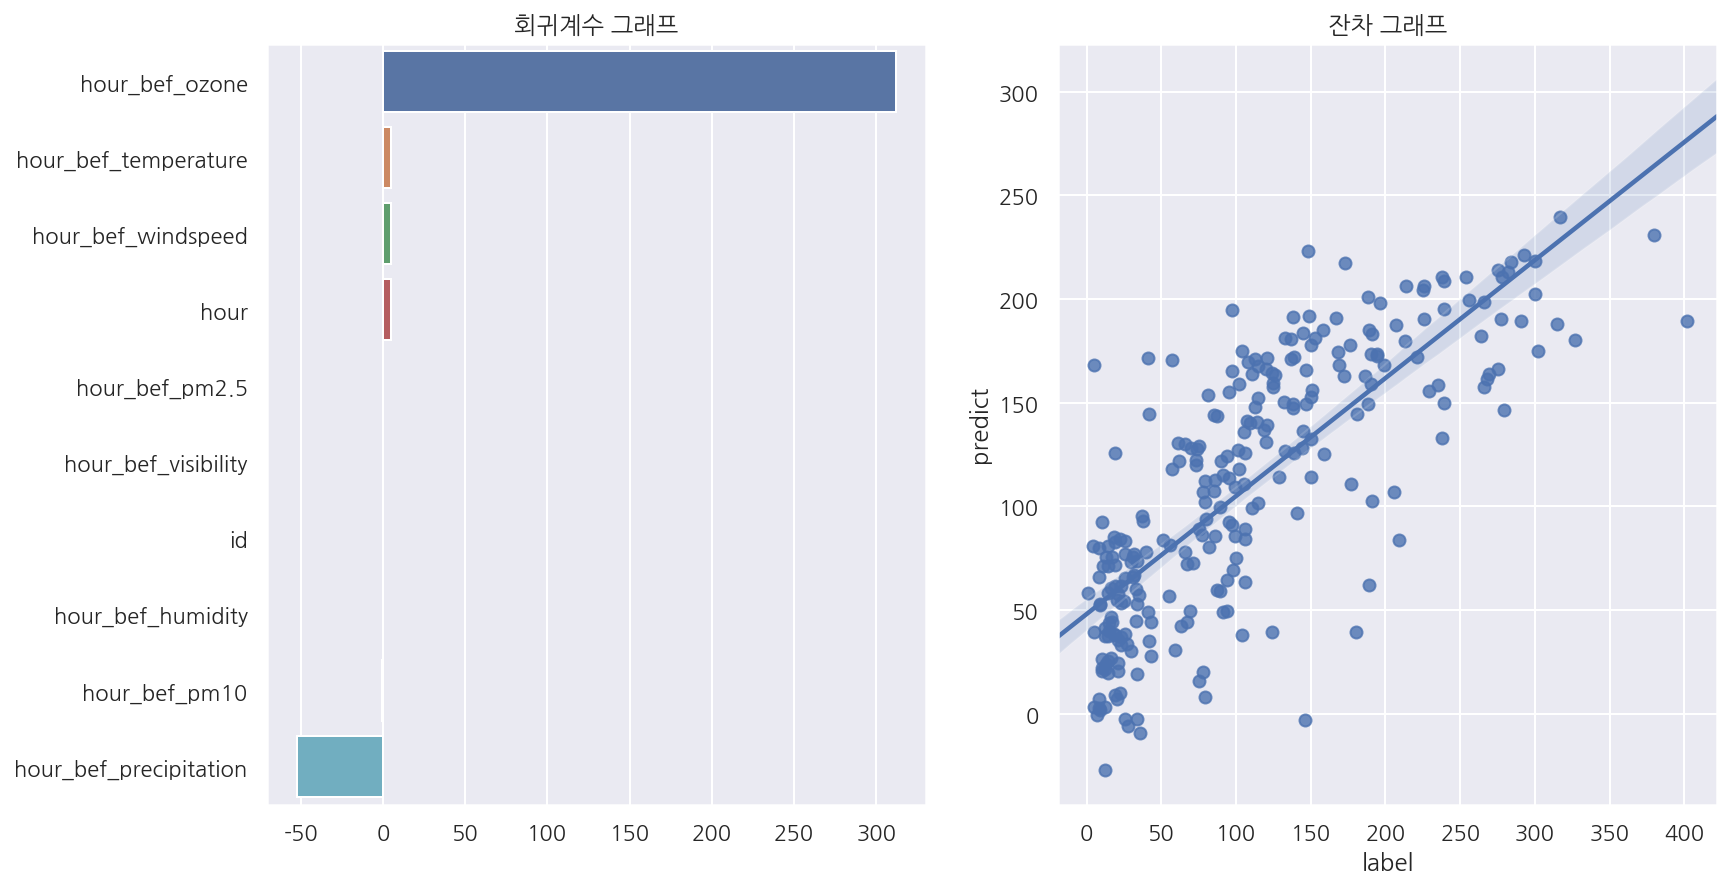

In [8]:
## 회귀계수 그래프
coef = pd.Series(base_model.coef_, index=features.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(base_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

####  < simple Feature Engineering & modeling version 1 >
    * 단순 식별자인 id 컬럼 제거
    * 데이터 표준화 진행 (Standard Scaling)
    * hour 피처의 원-핫 인코딩

Text(0.5, 1.0, '시간대별 대여횟수 평균')

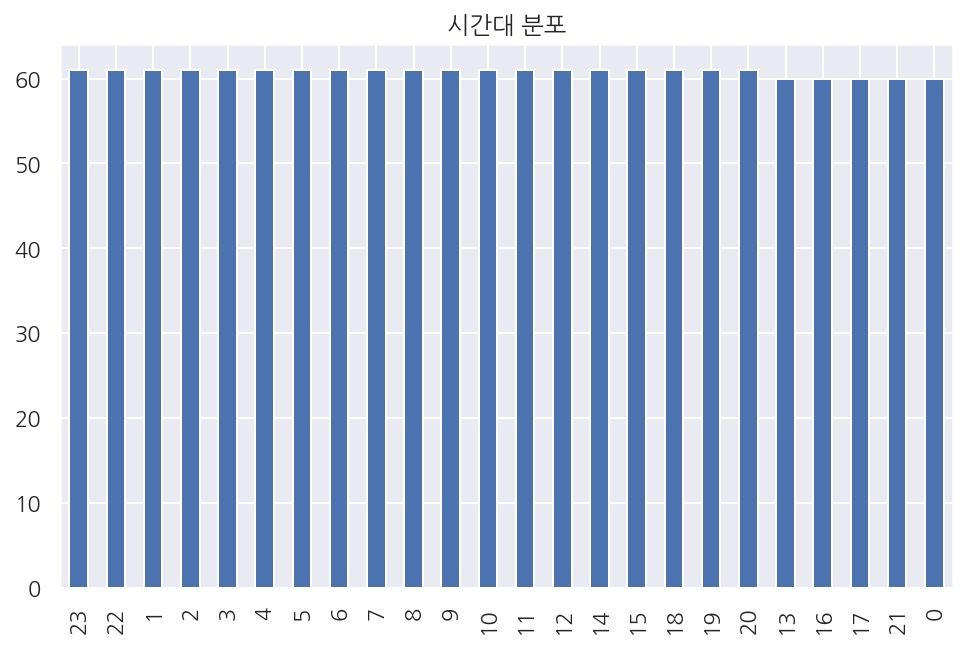

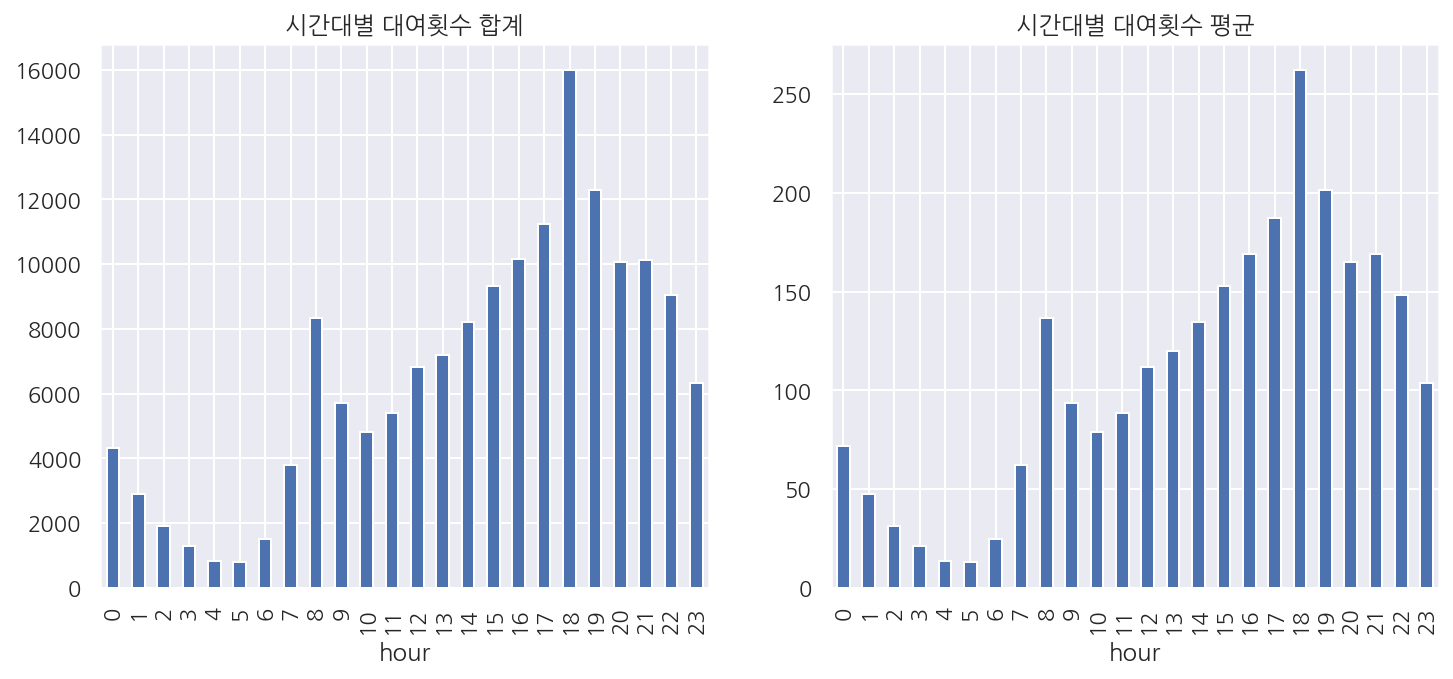

In [9]:
# 시간대 분포
plt.figure(figsize=(8,5))
train['hour'].value_counts().plot(kind='bar')
plt.title("시간대 분포")

# 시간대별 대여횟수 분포 # 합계
plt.figure(figsize=(12,5))
plt.subplot(121)
train.groupby('hour')['count'].sum().plot(kind='bar')
plt.title("시간대별 대여횟수 합계")

# 시간대별 대여횟수 분포 # 평균
plt.subplot(122)
train.groupby('hour')['count'].mean().plot(kind='bar')
plt.title("시간대별 대여횟수 평균")

* 시간대의 경우 데이터 내에 0~24시가 균등하게 분포하고 있음
* 시간대별 대여횟수의 경우 시간대별로 확연한 차이가 보임.
    * 0~6시까지는 가장 낮은 대여횟수를 보이며 감소추세임.
    * 7,8시부터 다시 대여횟수가 증가함. 또, 17,18,19시에 가장 높은 대여횟수를 가지는것으로 보아 출퇴근시에 따릉이를 이용하는 사람들이 많은것으로 보임.
* 시간대별로 확연한 차이가 보이므로 원-핫 인코딩을 통해 개별 피처로 활용할것.
    * 선형 모델의 경우 one-hot 피처로
    *  Tree 기반 회귀의 경우 one-hot 피처로 변경하지 않을것.[(참고)](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

* regplot을 통한 타겟(count)과 변수관 관계 파악

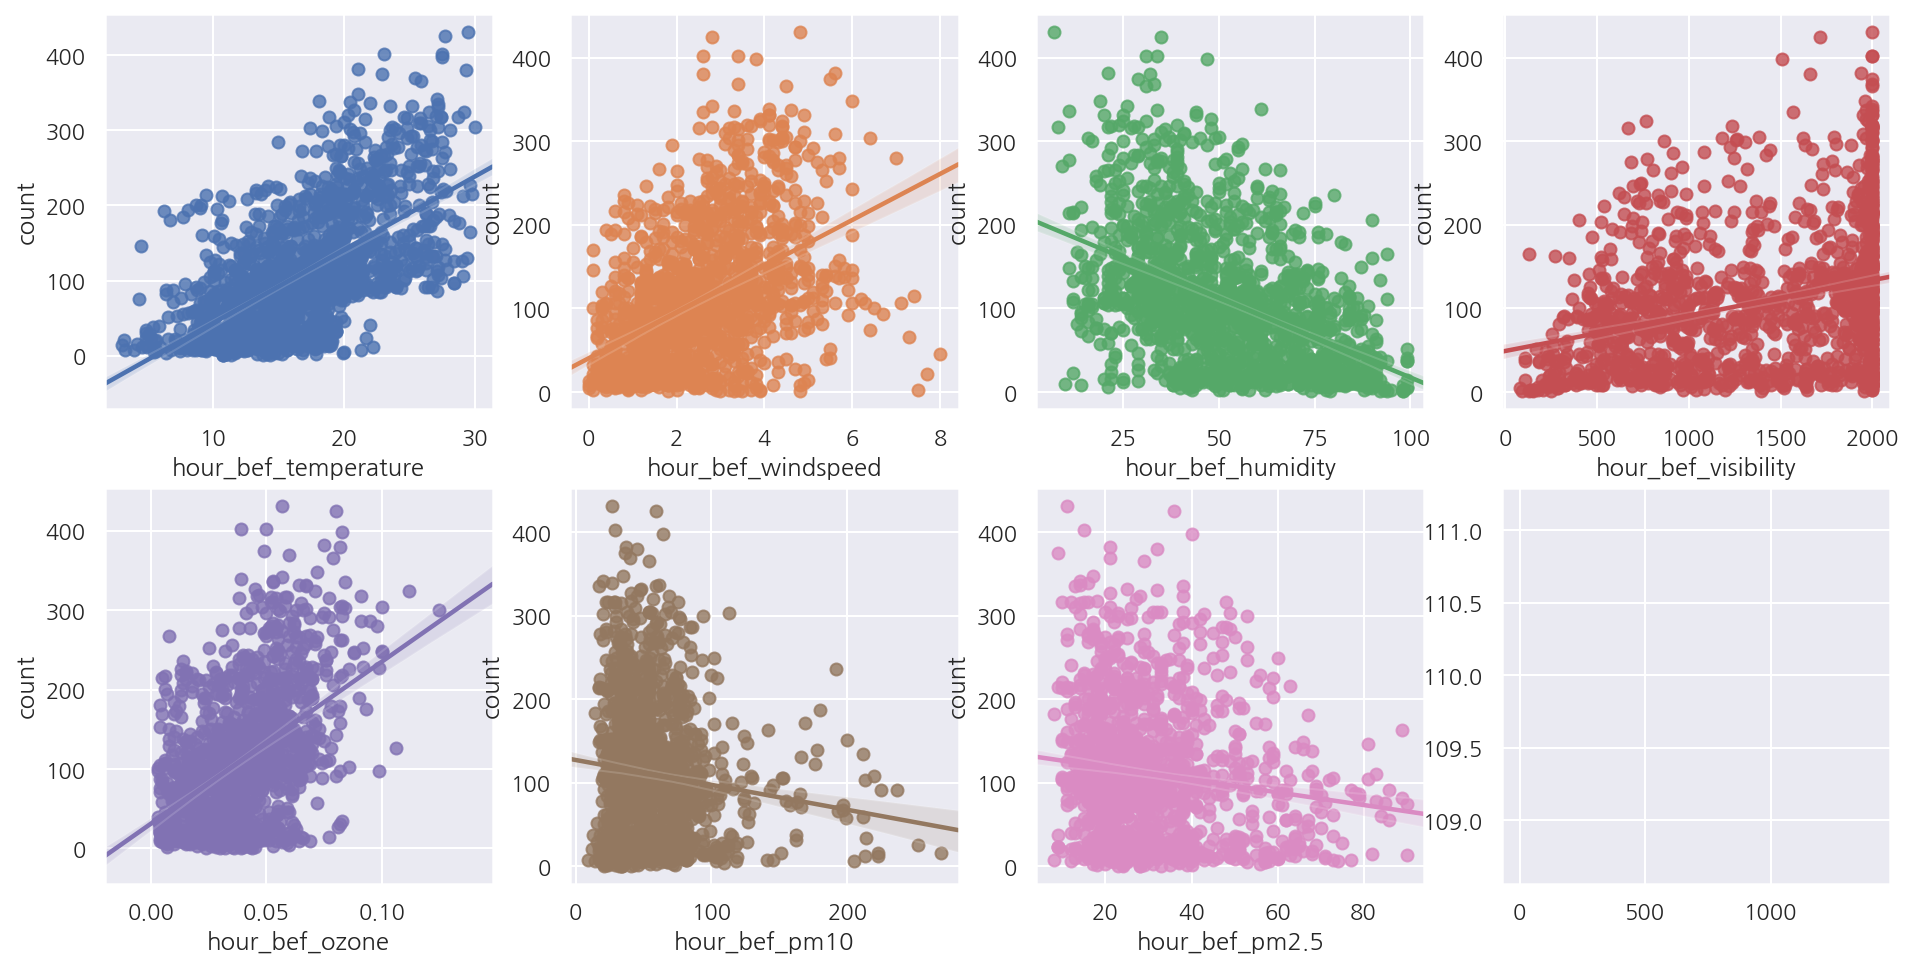

In [10]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity',
               'hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']

for i,feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='count',data=train, ax=axs[row][col])

* 전처리 진행 후 modeling
    * id컬럼 제거
    * standard scaling
    * hour, precipitation(강수여부) 원-핫 인코딩
    * 모델은 Simple Linear Regression

In [11]:
# 전처리 후 train/test 반환
## 단순 식별자인 id컬럼 제거
## 데이터 표준화 진행
def data_preprocessing_lr_v1(data):
    
    data = data.copy()
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = data.dropna().loc[:,:"hour_bef_pm2.5"] # 결측값 제거 # 피처 선택
    target = data.dropna()['count'] # target
    
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    
    res_df = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_df[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(res_df,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,res_df

    
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v1(train)   


# model _ 1
model_1 = LinearRegression()

model_1.fit(X_train,y_train)

model_1_pred = model_1.predict(X_test)

model_1_scores = cross_val_score(model_1, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_1_rmse_scores = np.sqrt(-1*model_1_scores)
model_1_rmse = np.mean(model_1_rmse_scores)

print("model_1 rmse : ",model_1_rmse)

model_1 rmse :  42.07340535856227


In [12]:
## 전처리 적용 후의 data
res_df.head(5)

,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,hour_0,hour_2,hour_3,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_bef_precipitation_0.0,hour_bef_precipitation_1.0
0,-0.108967,-0.716090,1.848215,-1.451638,-0.622533,0.593375,0.177633,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.622564,-0.788435,-0.185569,-0.862425,0.149769,0.497250,0.652684,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.570987,-1.294846,1.352170,-0.054858,-0.313612,-0.816461,-0.772469,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-1.687533,0.152043,0.112058,-0.810436,0.046796,0.561333,2.281431,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,2.432140,1.671277,-2.219352,1.016123,0.922071,-0.976669,-1.315385,0,0,0,...,0,0,1,0,0,0,0,0,1,0


* 간단한 데이터 전처리만으로도 base model에 비해 예측성능이 크게 향상되었음.

* 각 피처의 회귀계수 값을 시각화해 본다.

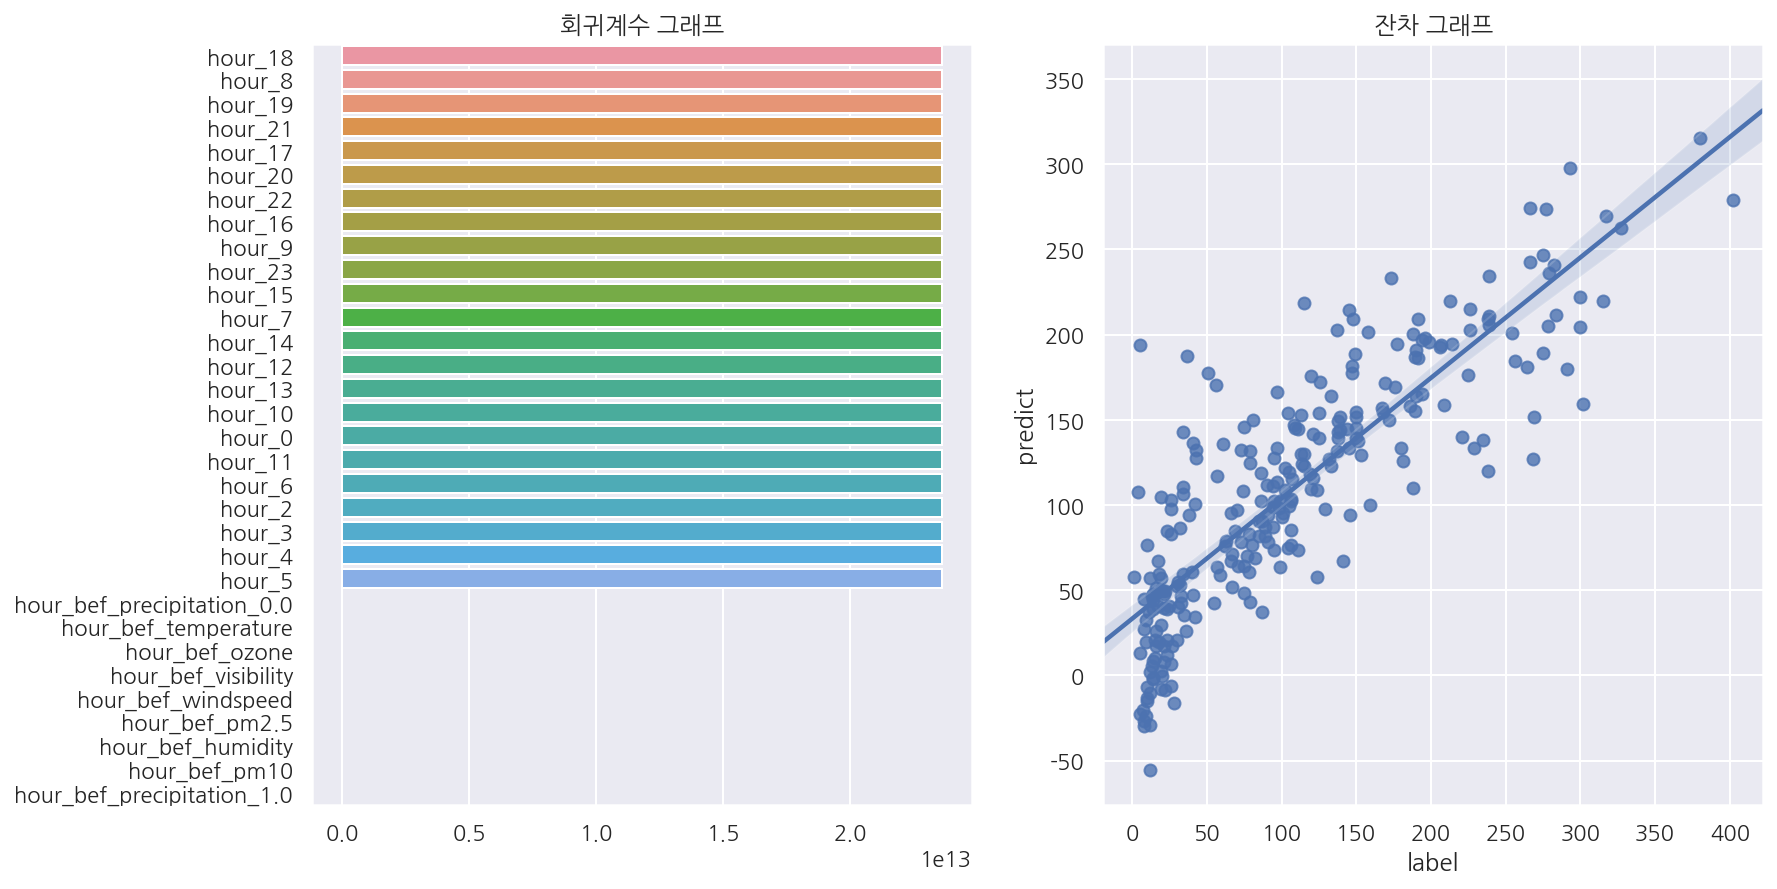

In [13]:
## 회귀계수 그래프
coef = pd.Series(model_1.coef_, index=res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_1_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* hour 피처들의 회귀 계수가 높다. (hour 외에는 영향을 미치는 피처가 없다..)
* hour들의 회귀계수가 전부 동일하게 계산되었다. 아마 무언가 잘못되었을 가능성이 큰.... 우선 진행해보고 차후에 검증해보자..

####  < simple Feature Engineering & modeling version 1 >
    * model_1의 데이터 전처리 과정에 결측값에 대한 부분이 빠져있다.
    * 결측값에 대한 전처리를 진행한 후 model_2를 만들어본다.

In [14]:
## 결측치 파악
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

* 모든 피처가 각 시간대의 정보를 담고 있다.
* 따라서 해당 피처의 시간대별 평균치로 결측값을 대체한다.
    * 단, 우천 여부를 나타내는 hour_bef_precipitation 컬럼의 경우 삭제한다.
    * ozone, pm10, pm2.5의 경우 1시에 측정된 값이 모두 결측치이다. 앞뒤 시간인 0,2시의 평균치로 대체한다.

In [15]:
def del_nan(df):
    df = df.copy()
    # 1차
    # 각 시간대별 평균값으로 결측치 대체
    df['hour_bef_temperature'].fillna(df.groupby('hour')['hour_bef_temperature'].transform('mean'),inplace=True)
    df['hour_bef_windspeed'].fillna(df.groupby('hour')['hour_bef_windspeed'].transform('mean'),inplace=True)
    df['hour_bef_humidity'].fillna(df.groupby('hour')['hour_bef_humidity'].transform('mean'),inplace=True)
    df['hour_bef_visibility'].fillna(df.groupby('hour')['hour_bef_visibility'].transform('mean'),inplace=True)
    df['hour_bef_ozone'].fillna(df.groupby('hour')['hour_bef_ozone'].transform('mean'),inplace=True)
    df['hour_bef_pm10'].fillna(df.groupby('hour')['hour_bef_pm10'].transform('mean'),inplace=True)
    df['hour_bef_pm2.5'].fillna(df.groupby('hour')['hour_bef_pm2.5'].transform('mean'),inplace=True)
    
    # 1차 결측치 삭제 후, ozone, pm10, pm2.5의 hour_1에 해당하는 결측치와 hour_bef_precipitation 결측치만 남음.
   # ozone, pm10, pm2.5 결측값을 hour_0, hour_2의 평균값으로 대체
    for col in ['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
        hour_0 = df[df['hour'] == 0][col].mean()
        hour_2 = df[df['hour'] == 2][col].mean()
        res = np.mean([hour_0,hour_2])
        df[col] = df[col].fillna(res)
        
    # hour_bef_precipitation 결측치 제거
#     df = df.dropna()
    df = df.fillna(0)
    
    return df

dropna_train = del_nan(train)

In [16]:
## 결측치 대체 후 
dropna_train.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

* 결측치 제거 완료 후, model_2 진행

In [17]:
# 전처리 후 train/test 반환
## 단순 식별자인 id컬럼 제거
## 데이터 표준화 진행
def data_preprocessing_lr_v2(df):
    
    df = df.copy()
    
    # 결측값 제거 
    df = del_nan(df)
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = df.loc[:,:"hour_bef_pm2.5"] # 피처 선택
    target = df['count'] # target
    
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    
    res_df = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_df[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(res_df,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,res_df

    
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v2(train)   


# model _ 2
model_2 = LinearRegression()

model_2.fit(X_train,y_train)

model_2_pred = model_2.predict(X_test)

model_2_scores = cross_val_score(model_2, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_2_rmse_scores = np.sqrt(-1*model_2_scores)
model_2_rmse = np.mean(model_2_rmse_scores)

print("model_2 rmse : ",model_2_rmse)

model_2 rmse :  42.99010885143


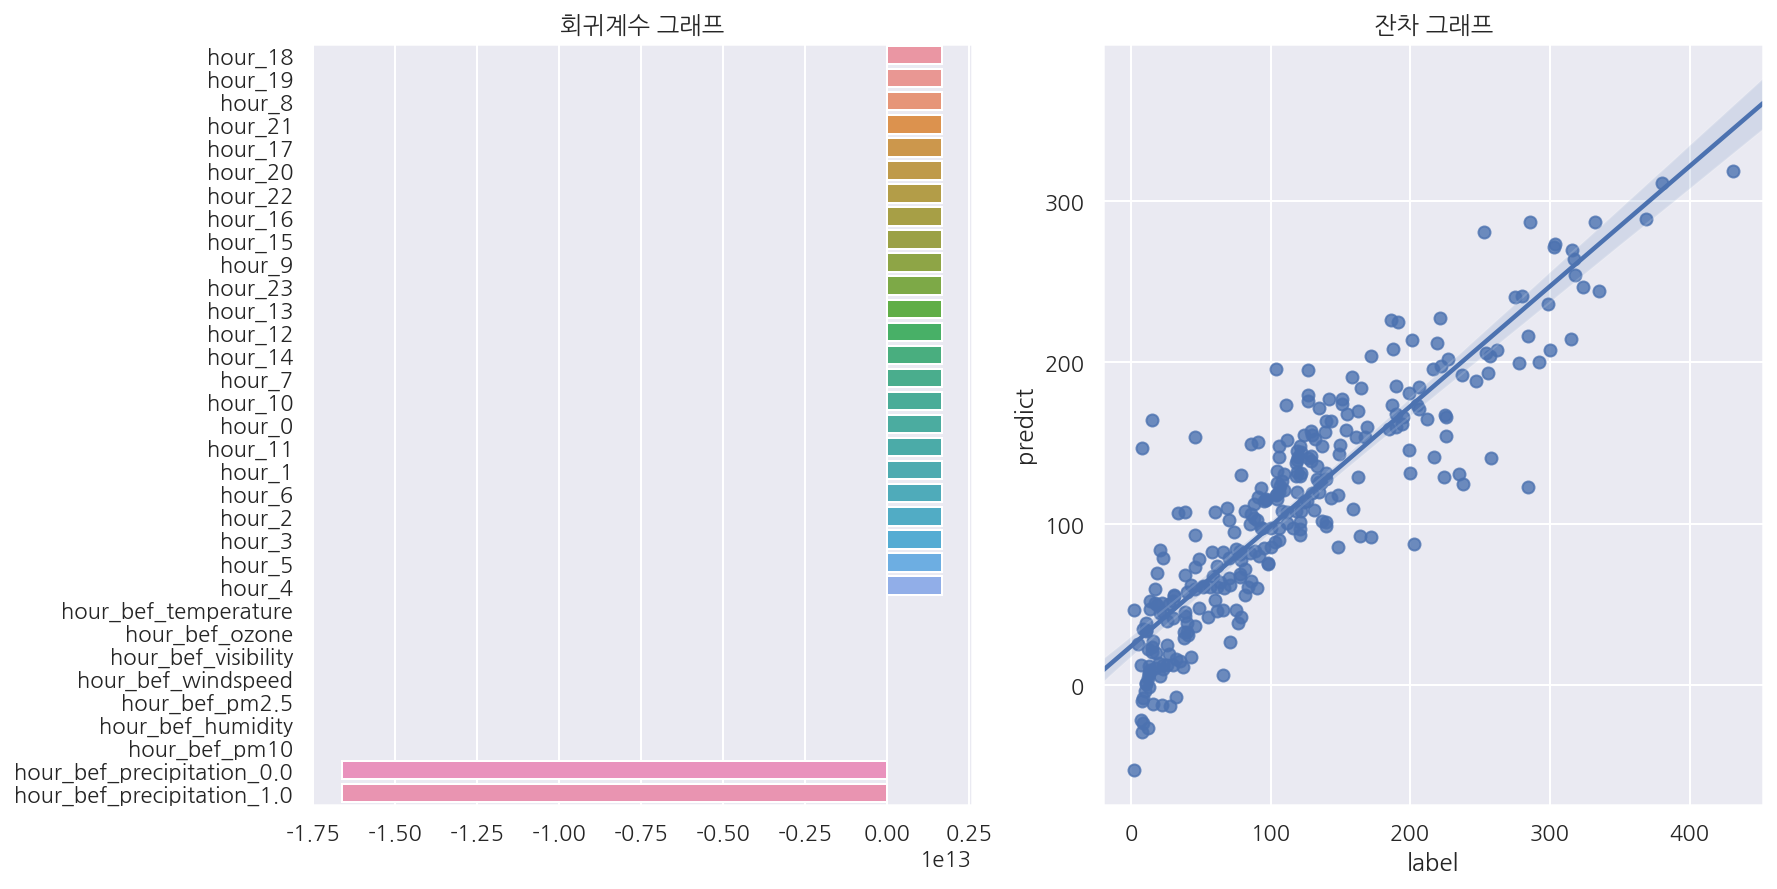

In [18]:
## 회귀계수 그래프
coef = pd.Series(model_2.coef_, index=res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_2_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* 회귀계수를 살펴보면 우천여부에 대한 피처가 높은 값을 보이는것을 알 수 있다.
    * 강수 여부가 자전거 대여 횟수에 큰 영향을 끼치는것으로 보인다.

#### < Ridge, Lasso, Elastic Net >
    * Ridge, Lasso, ElasticNet을 통해 선형 모델링에 L1,L2의 규제를 적용해본다.

In [19]:
# Ridge / Lasso / Elastic Net
def find_best_params(data, model, params):
    
    X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v2(data)
    
    grid_model = GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=3)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 3 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                             np.round(rmse,4),grid_model.best_params_))
    
    
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 10, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}   
elastic_params = {'alpha':[0.001,0.05, 0.1, 0.5, 1],
                 'l1_ratio':[0.1,0.5,1,5]}

find_best_params(train,ridge,ridge_params)
find_best_params(train,lasso,lasso_params)
find_best_params(train,elastic,elastic_params)

Ridge 3 CV 시 최적 평균 RMSE 값:43.0538, 최적 alpha:{'alpha': 1}
Lasso 3 CV 시 최적 평균 RMSE 값:43.0307, 최적 alpha:{'alpha': 0.05}
ElasticNet 3 CV 시 최적 평균 RMSE 값:43.0307, 최적 alpha:{'alpha': 0.05, 'l1_ratio': 1}


In [20]:
# Ridge, Lasso ElasticNet의 Best Parameter 값으로 훈련

# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v2(train)

model_ridge = Ridge(alpha=1)
model_ridge.fit(X_train,y_train)

model_lasso = Lasso(alpha=0.05)
model_lasso.fit(X_train,y_train)

model_elastic = ElasticNet(alpha=0.05, l1_ratio=0.1)
model_elastic.fit(X_train,y_train)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

* RMSE 값이 크게 개선되지는 않았다.
* Ridge, Lasso, Elastic Net 모델별 회귀계수를 살펴본다

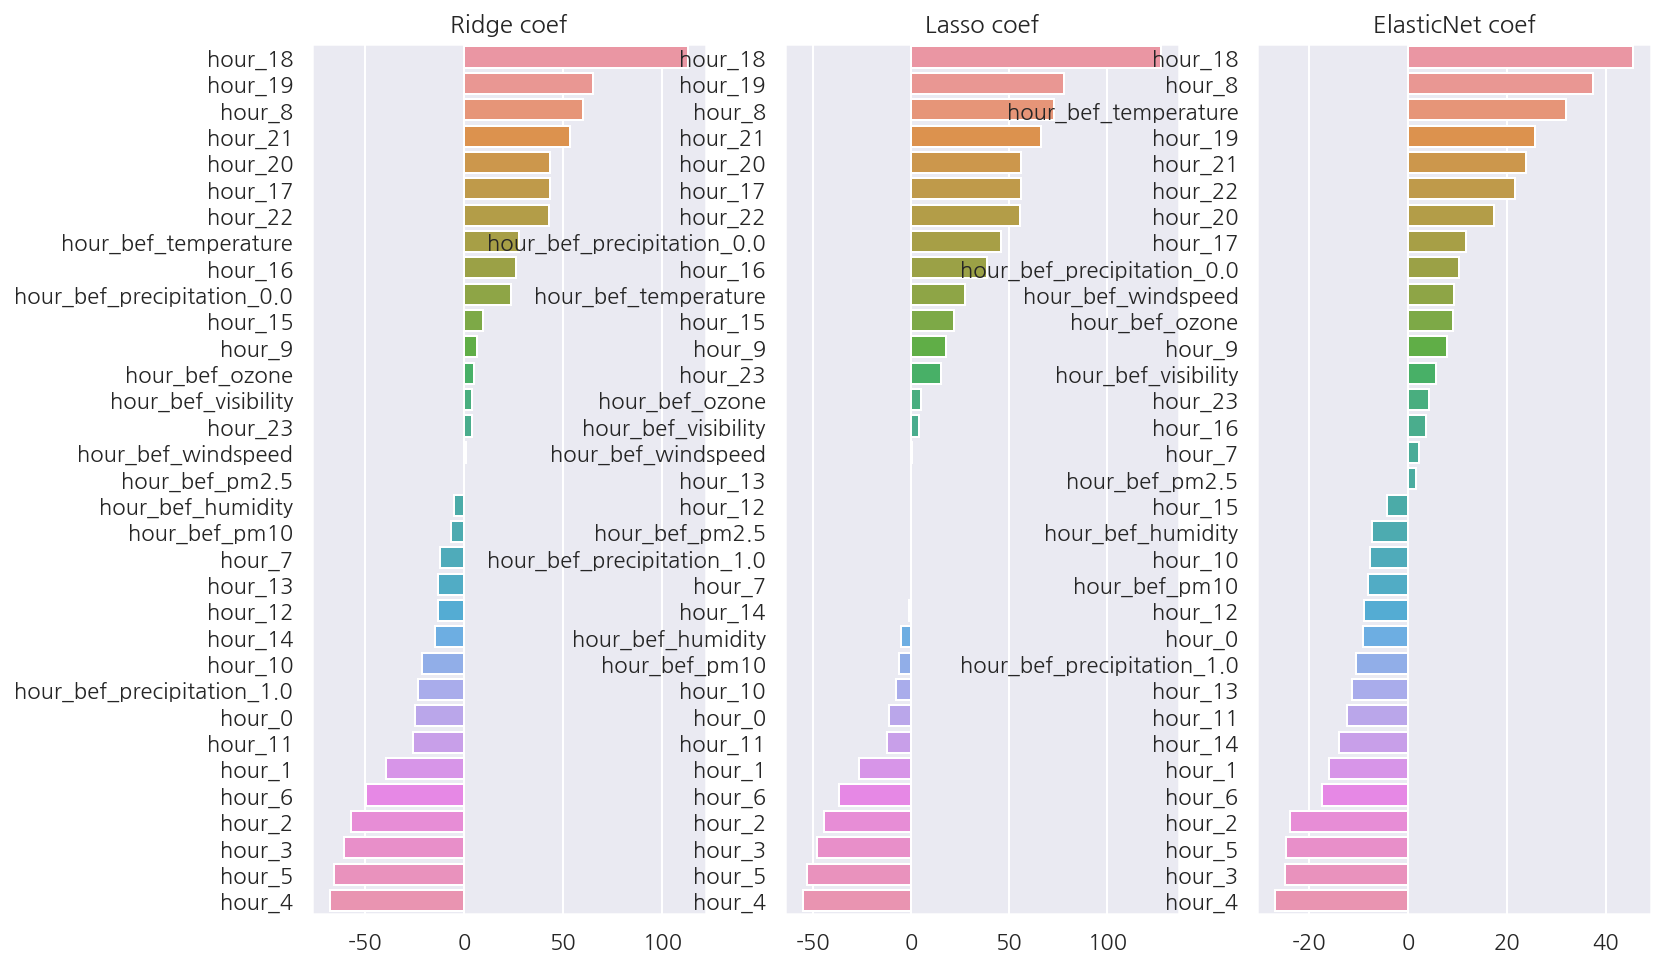

In [21]:
coef = pd.Series(model_ridge.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.title('Ridge coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

coef = pd.Series(model_lasso.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.subplot(1,3,2)
plt.title('Lasso coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

coef = pd.Series(model_elastic.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.subplot(1,3,3)
plt.title('ElasticNet coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

#### < Tree based Regression >

In [22]:
def data_preprocessing_nlr(df): # for not Linear
    
    df = df.copy()
    
#     결측값 제거
    df = del_nan(df)
    
    features = df.loc[:,:"hour_bef_pm2.5"]  # 피처 선택
    target = df['count'] # target
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,features


# RandomForestRegressor
def find_best_params(data, model, params):
    
    X_train,X_test,y_train,y_test,res_df = data_preprocessing_nlr(data)
    
    grid_model = GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=3)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 3 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                             np.round(rmse,4),grid_model.best_params_))
    
    
RandomForest = RandomForestRegressor(random_state=3)
RandomForest_params = {'n_estimators':[300,500],
                 'max_depth':[3,6,12,15,21]}

find_best_params(train,RandomForest,RandomForest_params)

RandomForestRegressor 3 CV 시 최적 평균 RMSE 값:40.7451, 최적 alpha:{'max_depth': 21, 'n_estimators': 500}


In [23]:
# RandomForest의 최적 파라미터 값으로 훈련

# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_nlr(train)

model_rf_v1 = RandomForestRegressor(n_estimators=500, max_depth=21, random_state=3)
model_rf_v1.fit(X_train,y_train)

model_rf_v1_pred = model_rf_v1.predict(X_test)

model_rf_v1_scores = cross_val_score(model_rf_v1, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_rf_v1_rmse_scores = np.sqrt(-1*model_rf_v1_scores)
model_rf_v1_rmse = np.mean(model_rf_v1_rmse_scores)

print("model_rf_v1 rmse : ",model_rf_v1_rmse)

model_rf_v1 rmse :  40.699946888157974


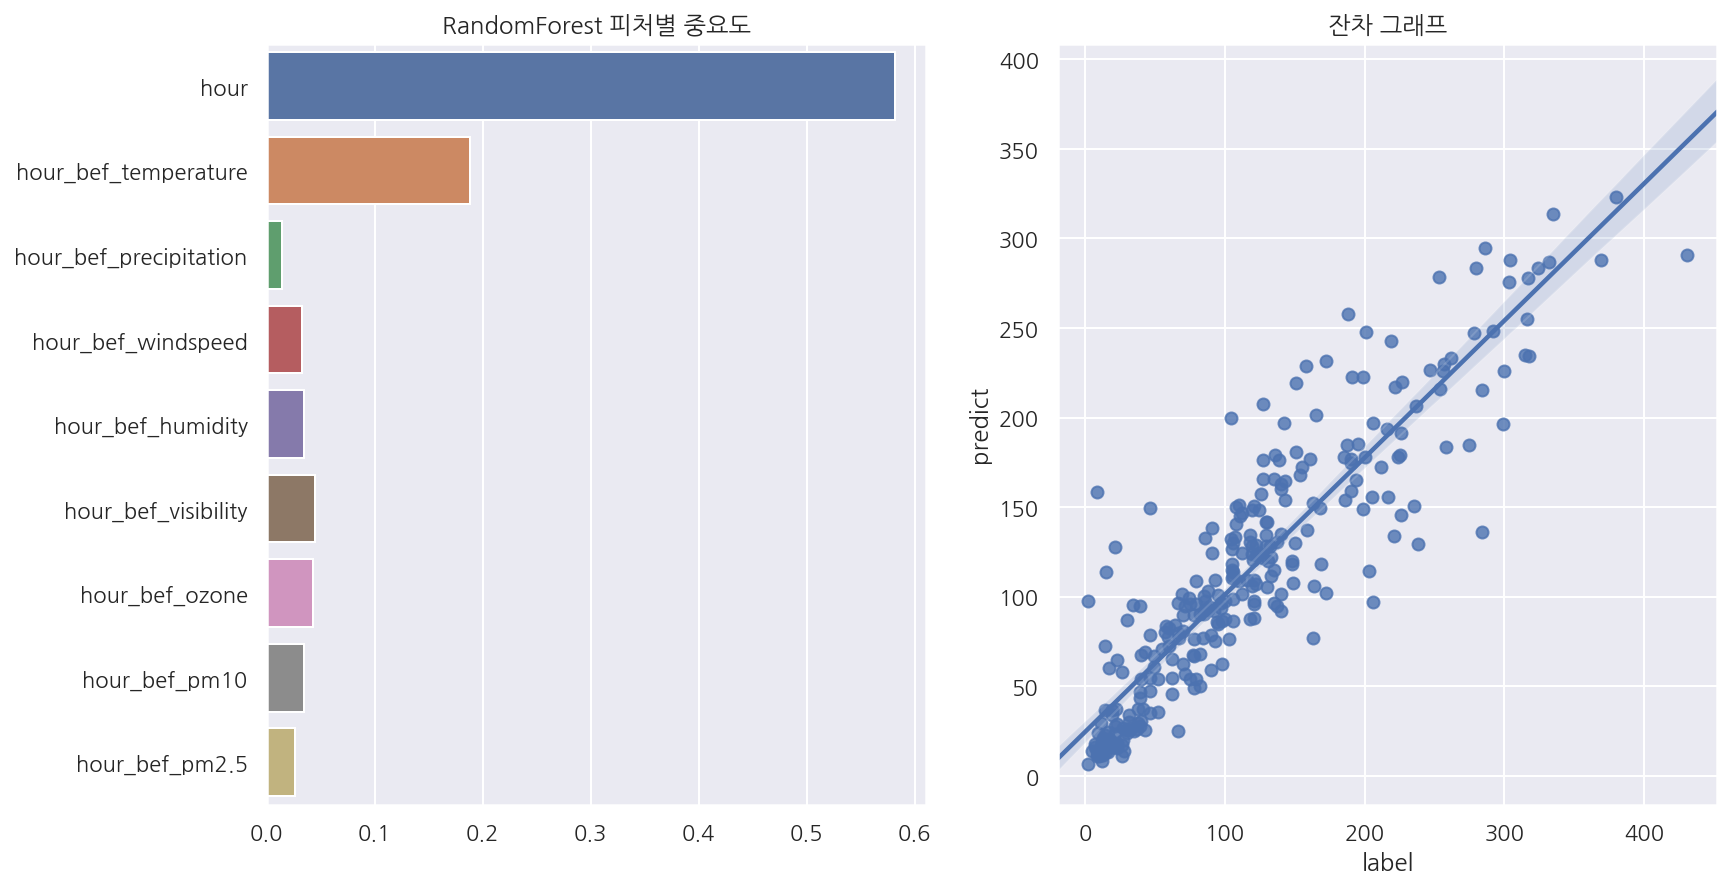

In [24]:
# RandomForest 피처 중요도 시각화
feature_series = pd.Series(data=model_rf_v1.feature_importances_, index=X_train.columns)
features_series = feature_series.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.barplot(x=feature_series, y=feature_series.index)
plt.title("RandomForest 피처별 중요도")

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_rf_v1_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

#### < 이상치 탐지 및 제거 >
    * 시간별 count, temperature에서 이상치 탐지 및 제거
    * [코드 참조](https://hong-yp-ml-records.tistory.com/15)

* 예시로 18시의 대여횟수를 살펴보자. 아래 box-plot을 살펴보면 범위에서 크게 벗어난 값 2개가 보인다. 이러한 이상치는 많은 이유로 발생할 수 있는데 자전거 점검 날이라던지 큰 태풍이 온 날이라던지 자전거 행사가 있다던지 등 다양한 외부,내부 요인이 있을 수 있을것이다.

* 각 시간별 IQR을 벗어나는 count데이터를 이상치로 판단하고 제거해 본다.
    * IQR? => Q3 - Q1: 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이

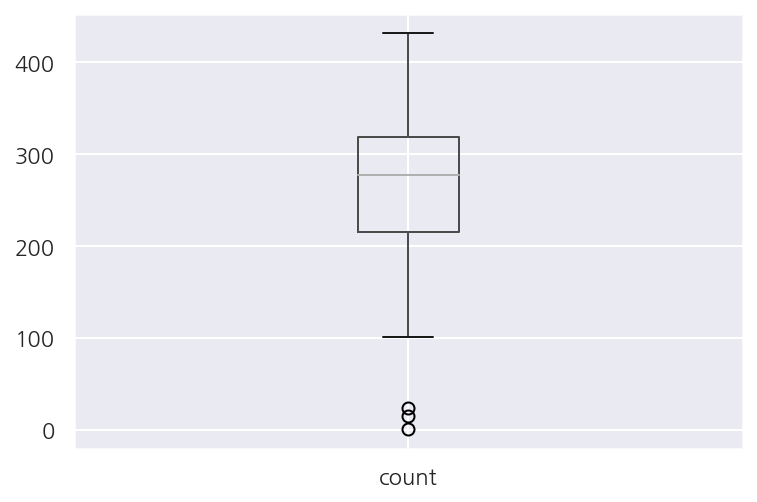

In [25]:
train[train['hour'] == 18][['count']].boxplot()

In [26]:
## 이상치 판별 함수
def detect_outliers(df, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    return outlier_indices

outliers_to_drop = detect_outliers(train[train['hour'] == 18][['count']], ["count"])
train[train.index.isin(outliers_to_drop)] # 이상치 row 

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
19,34,18,18.0,1.0,1.9,82.0,685.0,0.044,99.0,42.0,15.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1113,1678,18,21.7,0.0,3.4,60.0,1920.0,0.025,37.0,21.0,24.0


In [27]:
## 이상치 제거 함수
def delete_outliers(df):
    
    df = df.copy()
    
    for hour in df['hour'].unique():
        del_list = detect_outliers(df[df['hour'] == hour][['count']], ['count'])
        
        df = df.drop(del_list, axis=0).reset_index(drop=True)
    
    return df


# nlr 전처리 함수에 이상치 제거 함수만 추가
def data_preprocessing_nlr(df): # for not Linear
    df = df.copy()
    
    # 결측값 제거
    df = del_nan(df)
    
    # outlier 제거
    df = delete_outliers(df)
    
    features = df.loc[:,:"hour_bef_pm2.5"]  # 피처 선택
    target = df['count'] # target
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,features

RandomForestRegressor 3 CV 시 최적 평균 RMSE 값:39.1897, 최적 alpha:{'max_depth': 21, 'n_estimators': 1000}
model_rf_v2 rmse :  39.2096495771494


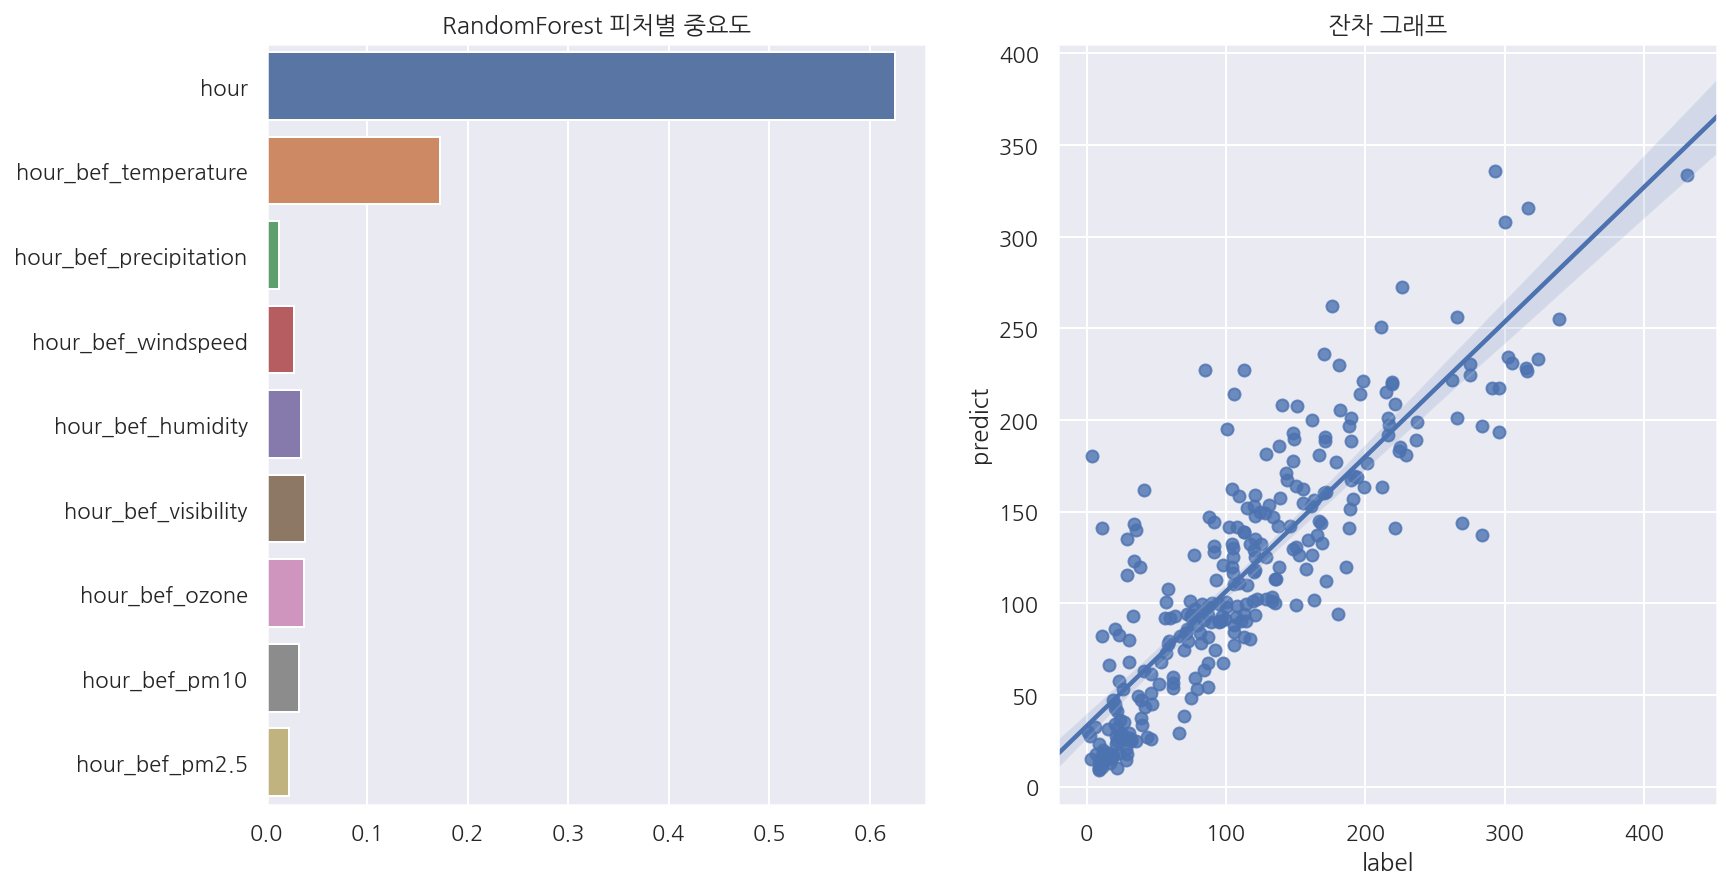

In [28]:
## 이상치 제거 후 RandomForestRegression

RandomForest = RandomForestRegressor(random_state=3)
RandomForest_params = {'n_estimators':[500,1000],
                 'max_depth':[16,21,32]}

find_best_params(train,RandomForest,RandomForest_params)

# RandomForest의 최적 파라미터 값으로 훈련
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_nlr(train)

model_rf_v2 = RandomForestRegressor(n_estimators=1000, max_depth=21, random_state=3)
model_rf_v2.fit(X_train,y_train)

model_rf_v2_pred = model_rf_v2.predict(X_test)

model_rf_v2_scores = cross_val_score(model_rf_v2, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_rf_v2_rmse_scores = np.sqrt(-1*model_rf_v2_scores)
model_rf_v2_rmse = np.mean(model_rf_v2_rmse_scores)

print("model_rf_v2 rmse : ",model_rf_v2_rmse)

# RandomForest 피처 중요도 시각화
feature_series = pd.Series(data=model_rf_v2.feature_importances_, index=X_train.columns)
features_series = feature_series.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.barplot(x=feature_series, y=feature_series.index)
plt.title("RandomForest 피처별 중요도")

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_rf_v2_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

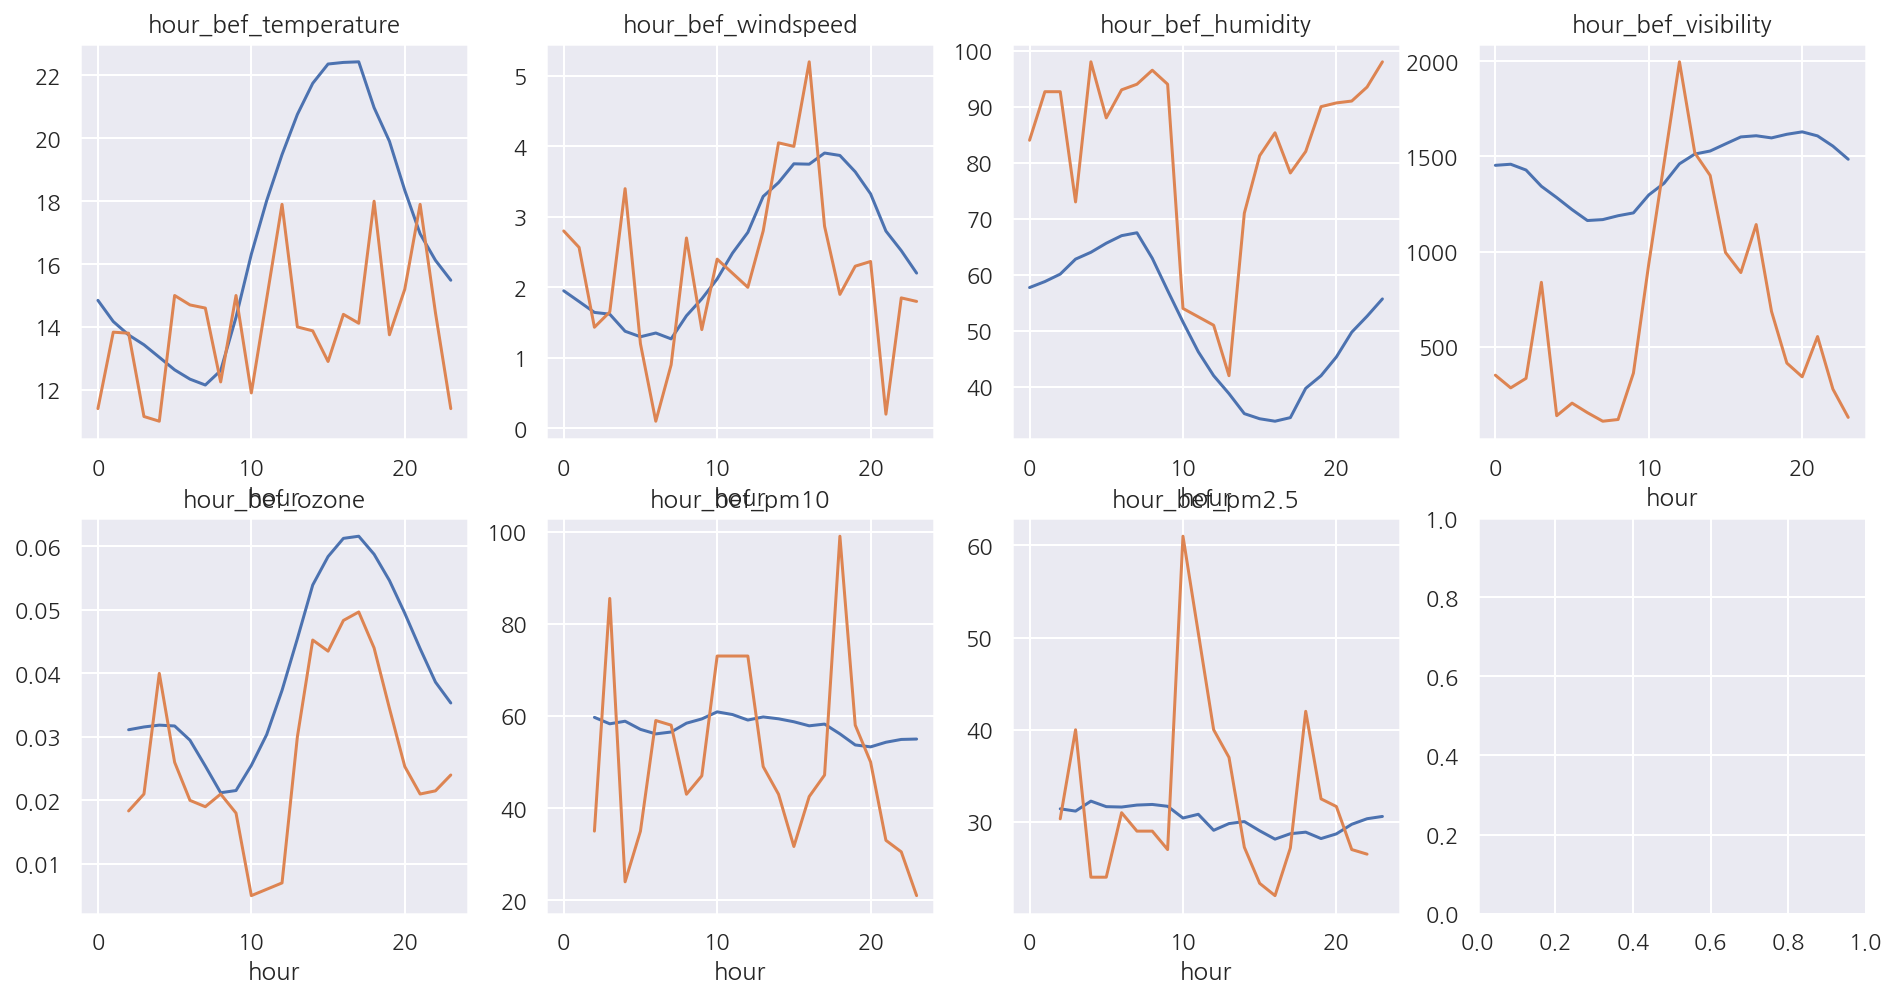

In [29]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
# fig.tight_layout()
weather_features = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity',
               'hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']

for i,feature in enumerate(weather_features):
    row = int(i/4)
    col = i%4
    train[train['hour_bef_precipitation'] == 0].groupby('hour')[feature].mean().plot(ax=axs[row][col],title=feature)
    train[train['hour_bef_precipitation'] == 1].groupby('hour')[feature].mean().plot(ax=axs[row][col])

* 결측값 처리에 대한 추가 아이디어.
    * 기존 결측값 처리 방식은 각 시간별 평균값으로 처리함.
    * 그러나 각 시간별 "기상상황"은 강수여부에 따라 크게 달라짐. (위의 그래프에서도 확인 가능)
    * 따라서 단순히 각 시간별 평균치가 아닌 시간별 강수여부에 따른 평균치로 대체할것.

In [310]:
train['hour_bef_temperature'].isnull().sum()

2

In [54]:
# 결측치 처리 ver_2
# 시간별 강수여부에 따른 평균치 대체

def del_nan_2(df):
    df = df.copy()
    # hour_bef_precipitation 결측치 제거
    df['hour_bef_precipitation'] = df['hour_bef_precipitation'].fillna(0)
    
    # 각 시간대별 평균값으로 결측치 대체
    df['hour_bef_temperature'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_temperature'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_temperature'].transform('mean'))
    df['hour_bef_temperature'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_temperature'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_temperature'].transform('mean'))
    
    df['hour_bef_windspeed'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_windspeed'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_windspeed'].transform('mean'))
    df['hour_bef_windspeed'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_windspeed'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_windspeed'].transform('mean'))
    
    df['hour_bef_humidity'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_humidity'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_humidity'].transform('mean'))
    df['hour_bef_humidity'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_humidity'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_humidity'].transform('mean'))
    
    df['hour_bef_visibility'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_visibility'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_visibility'].transform('mean'))
    df['hour_bef_visibility'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_visibility'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_visibility'].transform('mean'))
    
    df['hour_bef_ozone'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_ozone'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_ozone'].transform('mean'))
    df['hour_bef_ozone'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_ozone'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_ozone'].transform('mean'))
    
    df['hour_bef_pm10'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_pm10'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_pm10'].transform('mean'))
    df['hour_bef_pm10'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_pm10'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_pm10'].transform('mean'))
    
    df['hour_bef_pm2.5'] = df[df['hour_bef_precipitation'] == 0]['hour_bef_pm2.5'].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')['hour_bef_pm2.5'].transform('mean'))
    df['hour_bef_pm2.5'] = df[df['hour_bef_precipitation'] == 1]['hour_bef_pm2.5'].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')['hour_bef_pm2.5'].transform('mean'))
  
    
    # 1차 결측치 삭제 후, ozone, pm10, pm2.5의 hour_1에 해당하는 결측치만 남음.
   # ozone, pm10, pm2.5 결측값을 hour_0, hour_2의 평균값으로 대체
    for col in ['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
        hour_0 = df[df['hour'] == 0][col].mean()
        hour_2 = df[df['hour'] == 2][col].mean()
        res = np.mean([hour_0,hour_2])
        df[col] = df[col].fillna(res)
        
    return df

In [309]:
train

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


* 결측치 제거 version_2를 적용하여 평가 및 최적 파라미터를 도출해 낸다.

In [33]:
# nlr 전처리 함수에 이상치 제거, 결측치 제거(ver2) 추가
def data_preprocessing_nlr(df): # for not Linear
    df = df.copy()
    
    # 결측값 제거
    df = del_nan_2(df)
    
    # outlier 제거
    df = delete_outliers(df)
    
    features = df.loc[:,:"hour_bef_pm2.5"]  # 피처 선택
    target = df['count'] # target
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,features

RandomForest = RandomForestRegressor(random_state=3)
RandomForest_params = {'n_estimators':[500,1000],
                 'max_depth':[16,21,32]}

find_best_params(train,RandomForest,RandomForest_params)

# RandomForest의 최적 파라미터 값으로 훈련
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_nlr(train)

model_rf_v2 = RandomForestRegressor(n_estimators=1000, max_depth=21, random_state=3)
model_rf_v2.fit(X_train,y_train)

model_rf_v2_pred = model_rf_v2.predict(X_test)

model_rf_v2_scores = cross_val_score(model_rf_v2, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_rf_v2_rmse_scores = np.sqrt(-1*model_rf_v2_scores)
model_rf_v2_rmse = np.mean(model_rf_v2_rmse_scores)

print("model_rf_v2 rmse : ",model_rf_v2_rmse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### < 최종 모델링 > 
    * 전체 전처리 과정을 모듈화
        * 선형 / 회귀 트리
    * 최적 모델로 전체 학습데이터 train 후 test 데이터에 대해 예측
        * 실제 제출 점수 확인

In [ ]:
## Full processing
## linear model

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

################################################

## train 전체 학습 
## 제출할 test로 예측
def res_data_preprocessing_lr(data):
    
    data = data.copy()
    
    # 결측값 제거
    data = del_nan(data)
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = data.loc[:,:] # 피처 선택
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    res_preprocessed_features = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_preprocessed_features[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # return res_df
    return res_preprocessed_features
    
# get final preprocessed train/test    
res_train = res_data_preprocessing_lr(train)
res_target = res_train['count']
res_train = res_train.drop(['count'],axis=1)

res_test = res_data_preprocessing_lr(test)

In [ ]:
# res _ model _ 1
# Simple LinearRegression
model_res_1 = LinearRegression()
model_res_1.fit(res_train,res_target)
res_1_predict = model_res_1.predict(res_test)

## submit
submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_1_predict

# submission.to_csv('res_model_1.csv',index=False)

In [ ]:
## Full processing
## not linear model

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

################################################

## train 전체 학습 
## 제출할 test로 예측
def res_data_preprocessing_nlr(data):
    
    data = data.copy()
    
    # 결측값 제거
#     data = del_nan(data)
    data = del_nan_2(data)
    
    # outlier 제거
    try:
        data = delete_outliers(data) 
    except:
        pass
    
    features = data.loc[:,:]  # 피처 선택
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # return res_df
    return features

    
# get final preprocessed train/test
train = delete_outliers(train) # res_2 모델 실행 시 주석처리.

res_train = res_data_preprocessing_nlr(train)
res_target = res_train['count']
res_train = res_train.drop(['count'],axis=1)

res_test = res_data_preprocessing_nlr(test)

In [ ]:
# res _ model _ 2
# RandomForest Regression
model_res_2 = RandomForestRegressor(n_estimators=500, max_depth=21)
model_res_2.fit(res_train,res_target)
res_2_predict = model_res_2.predict(res_test)

## submit
submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_2_predict

submission.to_csv('res_model_2.csv',index=False)

In [ ]:
# res _ model _ 3
# RandomForest Regression
# 이상치 제거
model_res_3 = RandomForestRegressor(n_estimators=1000, max_depth=21)
model_res_3.fit(res_train,res_target)
res_3_predict = model_res_3.predict(res_test)

## submit
submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_3_predict

submission.to_csv('res_model_3.csv',index=False)

In [307]:
tmp = pd.DataFrame({"hour":[12,12,13,13,14,14,15,15], "A":[0,1,0,1,0,1,0,0], "B":[], "C":[None,None,8,None]})
tmp

,A,B,C
0,0,NaN,3
1,0,NaN,6
2,0,8.0,9
3,1,NaN,12


In [308]:
tmp.loc[tmp['B'].isnull(), 'B'] = tmp['A']
tmp

,A,B,C
0,0,0.0,3
1,0,0.0,6
2,0,8.0,9
3,1,1.0,12


In [298]:
tmp['B'] = tmp[tmp['A'] == 0]['B'].fillna(0)
display(tmp)
tmp['B'] = tmp[tmp['A'] == 1]['B'].fillna(1)
display(tmp)

,A,B,C
0,0,0.0,3
1,0,0.0,6
2,0,8.0,9
3,1,NaN,12


,A,B,C
0,0,NaN,3
1,0,NaN,6
2,0,NaN,9
3,1,1.0,12
